In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

from copy import deepcopy
import itertools
import json
from pathlib import Path
import pickle

import pandas as pd
from scipy.io import savemat, loadmat
import seaborn as sns
from sklearn.metrics import (log_loss, mean_squared_error, roc_curve, auc,
                             precision_recall_fscore_support, confusion_matrix)
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from tqdm import tqdm, trange, tqdm_notebook as tqdmn

from BEKML import BEMKL, plot_distplot
from utils import poly_kernel, gauss_kernel, scoring, plot_kernel_importances, plot_compare_models

sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [137]:
datasets = {
    fname.stem.replace('proc_', ''): pd.read_csv(fname)
    for fname in Path('data/').glob('proc_*.csv')
}

In [19]:
cwd = Path('.').resolve()

results = []
for f in cwd.glob('*_results.json'):
    with f.open() as fp:
        results.append((f.stem, json.load(fp)))

len(results), results[0]

(6,
 ('breast_results',
  {'base': {'kernels': [130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130,
     130],
    'scores': [0.8947368421052632,
     0.8830409356725146,
     0.8830409356725146,
     0.8588235294117647,
     0.8771929824561403,
     0.8830409356725146,
     0.847953216374269,
     0.8823529411764706,
     0.8713450292397661,
     0.9064327485380117,
     0.8713450292397661,
     0.8823529411764706,
     0.8713450292397661,
     0.8771929824561403,
     0.847953216374269,
     0.9117647058823529,
     0.9005847953216374,
     0.8654970760233918,
     0.8538011695906432,
     0.8941176470588236],
    'svs': [467,
     471,
     485,
     487,
     434,
     492,
     455,
     476,
     488,
     459,
     480,
     473,
     481,
     470,
     469,
     488,
     442,
     470,
     447,
     497],
    'times': [10.4588463306427,
     10

In [153]:
df = pd.DataFrame()
model_type = {
    'base': 'dense',
    'ksparse': 'kernel_sparse',
    'ssparse': 'sv_sparse',
}
for exp_name, result in results:
    for key, val in result.items():
        if key in ('total_kernels', 'total_sv'):
            continue
        df_res = pd.DataFrame()
        df_res['kernel_nr'] = val['kernels']
        df_res['acc_score'] = val['scores']
        df_res['sv_nr'] = val['svs']
        df_res['train_time'] = val['times']
        df_res['total_kernels'] = result['total_kernels']
        df_res['total_sv'] = result['total_sv']
        df_res['model_type'] = model_type[key]
        df_res['experiment'] = exp_name.replace('_results', '')
        df_res['kernel_frac'] = df_res['kernel_nr']/df_res['total_kernels']
        df_res['sv_frac'] = df_res['sv_nr']/df_res['total_sv']
        df = df.append(df_res)
df.sample(10)

,kernel_nr,acc_score,sv_nr,train_time,total_kernels,total_sv,model_type,experiment,kernel_frac,sv_frac
4,3,0.795918,139,5.842489,442,135,kernel_sparse,wpbc,0.006787,1.029630
11,2,0.791667,141,6.117959,442,135,kernel_sparse,wpbc,0.004525,1.044444
18,190,0.730769,150,19.063439,780,145,dense,sonar,0.243590,1.034483
11,3,0.936620,321,20.383494,403,398,kernel_sparse,wdbc,0.007444,0.806533
10,130,0.871345,480,10.678359,130,478,dense,breast,1.000000,1.004184
7,432,0.729167,103,6.879850,442,135,dense,wpbc,0.977376,0.762963
9,9,0.718750,428,10.898598,117,537,sv_sparse,pima,0.076923,0.797020
15,11,0.651042,437,10.897819,117,537,sv_sparse,pima,0.094017,0.813780
8,3,0.830189,28,18.837275,780,145,sv_sparse,sonar,0.003846,0.193103
12,38,0.877193,484,10.659613,130,478,kernel_sparse,breast,0.292308,1.012552


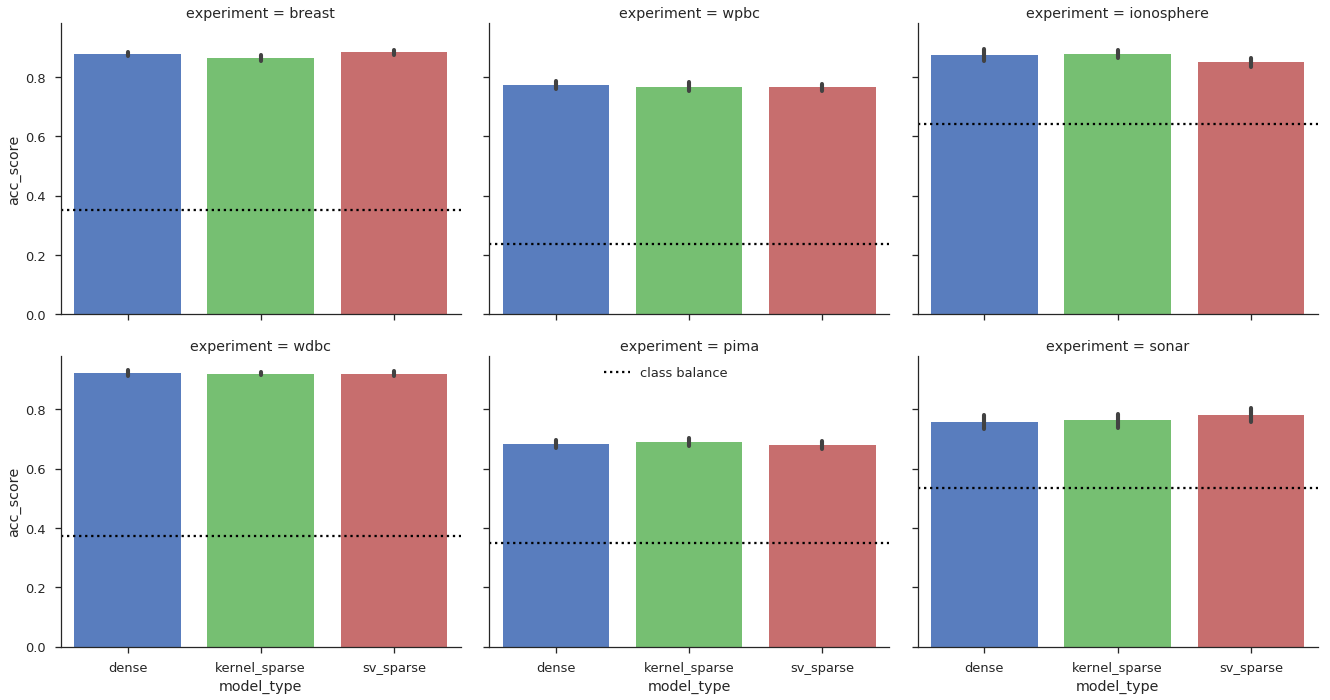

In [163]:
grid = sns.factorplot(x="model_type", y="acc_score", col="experiment", data=df,
                      size=5, aspect=1.25, kind="bar", col_wrap=3, palette="muted");

for ax, exp_name in zip(grid.axes, grid.col_names):
    y = datasets[exp_name].iloc[:, -1]
    mean_pos = (y == 1).mean()
    ax.axhline(mean_pos, color='k', ls=':', label='class balance')
grid.fig.legend(loc=(0.45, 0.45));

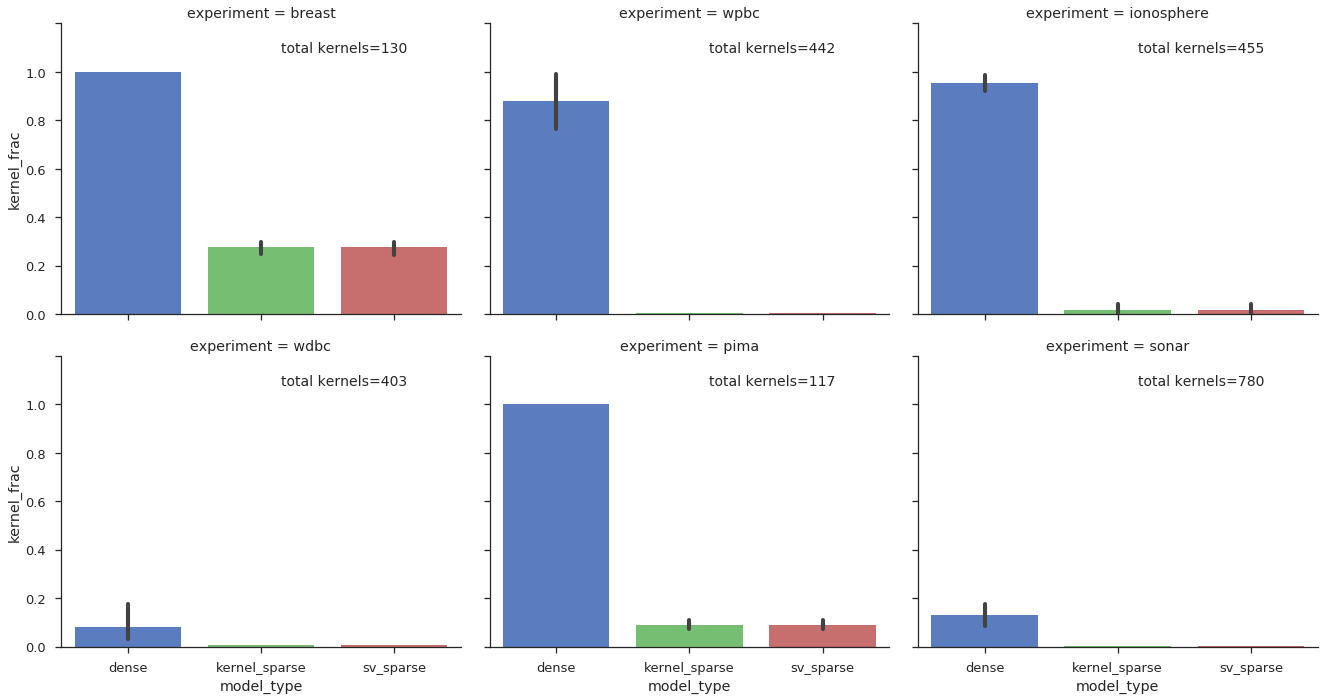

In [162]:
grid = sns.factorplot(x="model_type", y="kernel_frac", col="experiment", data=df,
                      size=5, aspect=1.25, kind="bar", col_wrap=3, palette="muted")
for ax, (_, data) in zip(grid.axes, grid.facet_data()):
    ax.annotate(f"total kernels={data.total_kernels.values[0]}", (0.55, 0.9), xycoords='axes fraction', size=14)
    ax.set_yticklabels(np.round(np.arange(0, 1.2, 0.2), 1))
    ax.set_ylim(0, 1.2)

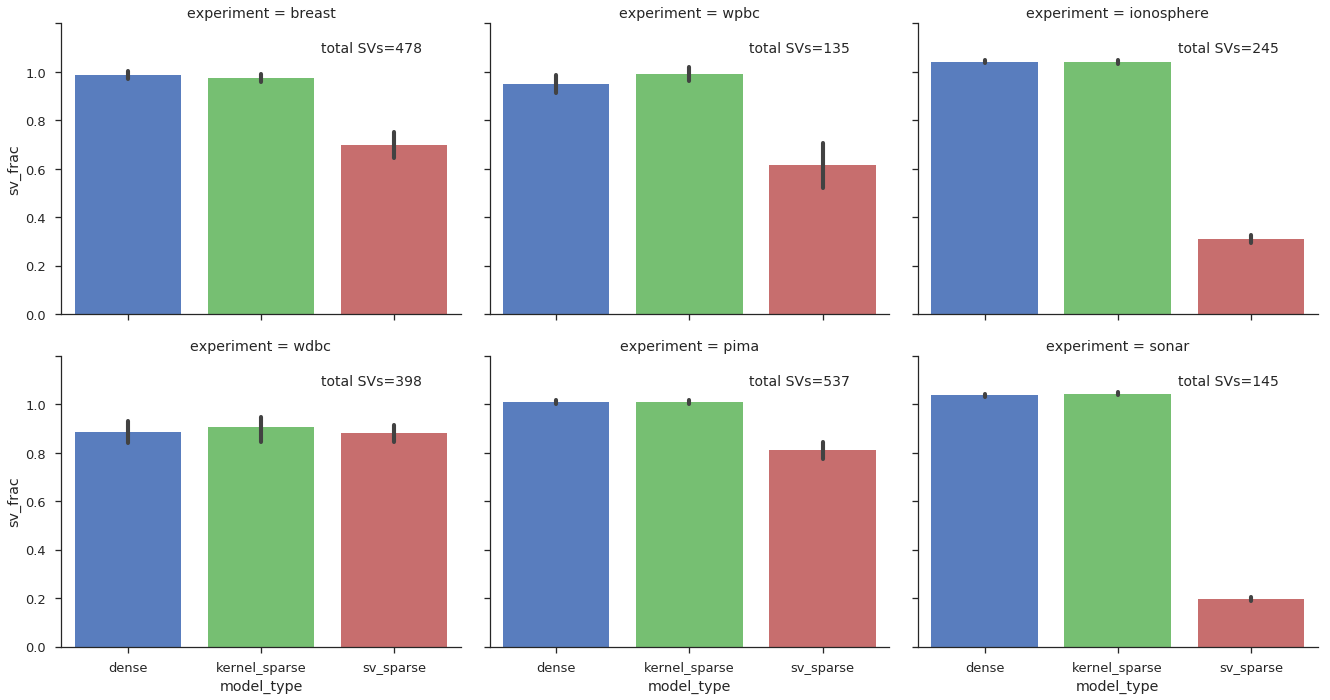

In [161]:
grid = sns.factorplot(x="model_type", y="sv_frac", col="experiment", data=df,
                      size=5, aspect=1.25, kind="bar", col_wrap=3, palette="muted")
for ax, (_, data) in zip(grid.axes, grid.facet_data()):
    ax.annotate(f"total SVs={data.total_sv.values[0]}", (0.65, 0.9), xycoords='axes fraction', size=14)
    ax.set_yticklabels(np.round(np.arange(0, 1.2, 0.2), 1))
    ax.set_ylim(0, 1.2)

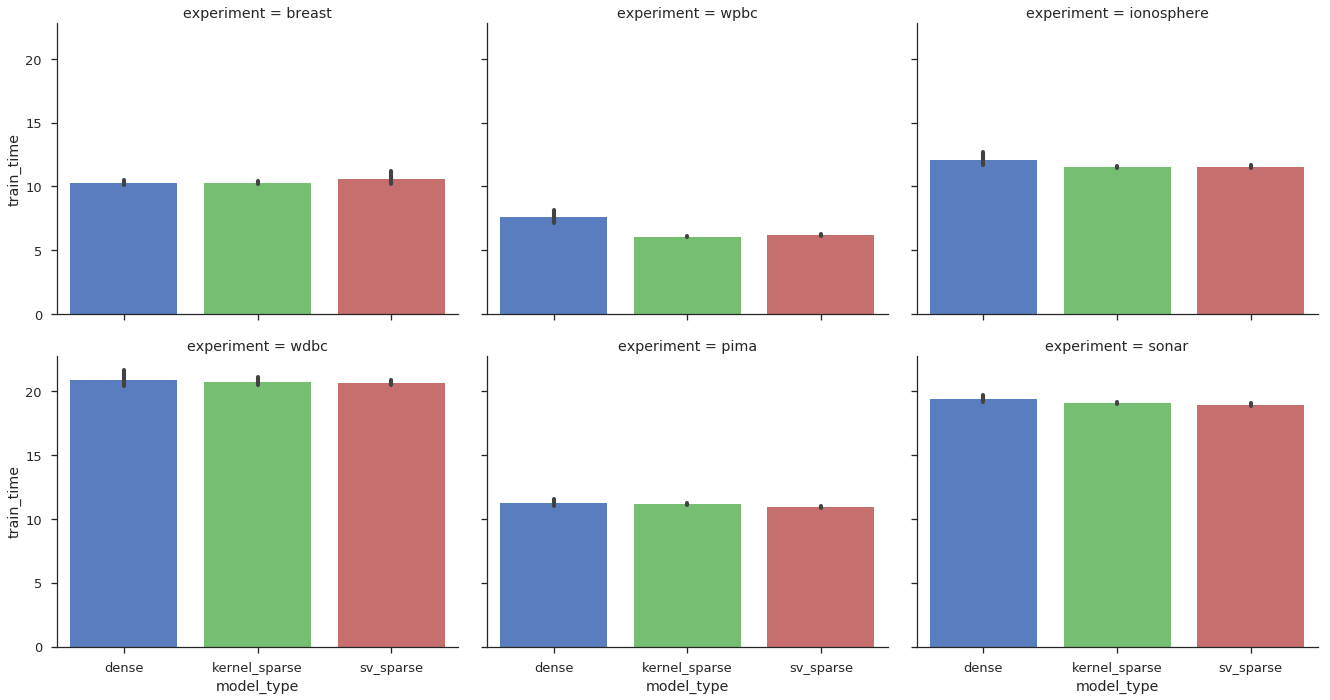

In [160]:
grid = sns.factorplot(x="model_type", y="train_time", col="experiment", data=df,
                      size=5, aspect=1.25, kind="bar", col_wrap=3, palette="muted");